# Imports and Configurations

### 1. Import Libraries

In [1]:
import os
import cv2
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models.video import r3d_18
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

### 2. Configurations

In [2]:
DATA_DIR = "/kaggle/input/shoplifting-dataset"
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-3
NUM_FRAMES = 16
IMG_SIZE = 112
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Preprocessing

### 1. Load Data

In [3]:
normal_videos = glob(os.path.join(DATA_DIR, "non-shoplifting", "*.mp4"))
shoplifting_videos = glob(os.path.join(DATA_DIR, "shoplifting", "*.mp4"))

all_videos = normal_videos + shoplifting_videos
all_labels = [0] * len(normal_videos) + [1] * len(shoplifting_videos)

### 2. Split Data into Train/Validation/Test Splits

In [4]:
train_videos, temp_videos, train_labels, temp_labels = train_test_split(all_videos, all_labels, test_size=0.2, shuffle=True, random_state=SEED, stratify=all_labels)
val_videos, test_videos, val_labels, test_labels = train_test_split(temp_videos, temp_labels, test_size=0.5, stratify=temp_labels)

print(f'Train Samples: {len(train_videos)}')
print(f'Validation Samples: {len(val_videos)}')
print(f'Test Samples: {len(test_videos)}')

Train Samples: 683
Validation Samples: 85
Test Samples: 86


### 3. Define Frame Sampling Function

In [5]:
def sample_uniform_frames(video_path, num_frames=NUM_FRAMES):
    """Uniformly sample frames from a video, pad if needed."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames >= num_frames:
        frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    else:
        frame_indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            frame = frames[-1]  # fallback to last frame if broken
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return np.array(frames)

### 4. Define VideoDataset Class

In [6]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = sample_uniform_frames(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        # Shape: (C, T, H, W)
        frames = torch.stack(frames).permute(1, 0, 2, 3)
        return frames, label

### 5. Transforms

In [7]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

### 6. Datasets and Loaders

In [8]:
train_dataset = VideoDataset(train_videos, train_labels, transform=train_transform)
val_dataset = VideoDataset(val_videos, val_labels, transform=val_test_transform)
test_dataset = VideoDataset(test_videos, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### 7. Show a Train Video's Frames Before and After Augmentation

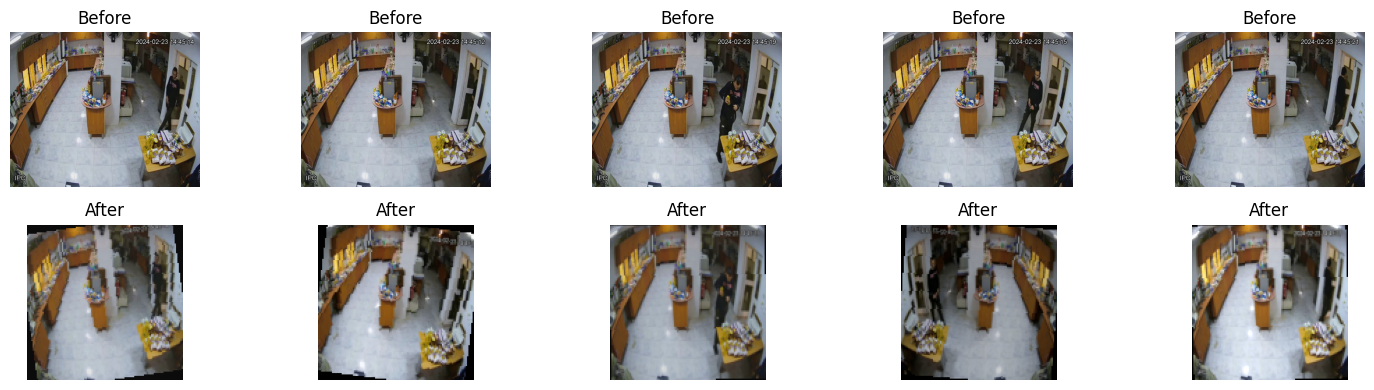

In [9]:
from PIL import Image

def show_video_frames_before_after(videos, transform, num_frames_to_show=5):
    """
    Display some frames from a video before and after augmentation.
    """
    # Randomly select a video
    video_path = random.choice(videos)

    # Sample the selected videos into frames
    frames = sample_uniform_frames(video_path)
    frames = list(frames)
    
    # Select random frames
    selected_frames = random.sample(frames, num_frames_to_show)
    
    fig, axes = plt.subplots(2, num_frames_to_show, figsize=(15, 4))
    
    for i, frame in enumerate(selected_frames):
        # Before augmentation
        axes[0, i].imshow(frame)
        axes[0, i].axis('off')
        axes[0, i].set_title("Before")
        
        # After augmentation
        aug_frame = transform(frame)
        aug_frame = aug_frame.permute(1, 2, 0)  # CHW → HWC
        axes[1, i].imshow(aug_frame)
        axes[1, i].axis('off')
        axes[1, i].set_title("After")
    
    plt.tight_layout()
    plt.show()

show_video_frames_before_after(train_videos, train_transform, num_frames_to_show=5)

# Modeling

### 1. Build Model

In [10]:
model = r3d_18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(model.fc.in_features, 2))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 187MB/s]


### 2. Define Traning and Evaluation Functions

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item(), all_preds, all_labels

### 3. Train Model

In [12]:
best_val_acc = 0.0
best_val_loss = 100.0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}")
    print(f"Val Loss: {val_loss:.4f}   | Val Accuracy: {val_acc*100:.2f}")

    if (val_acc > best_val_acc) or ((val_acc == best_val_acc) and (val_loss < best_val_loss)):
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_3D_CNN_model.pth")
        print("✅ Saved Best Model")

Epoch 1/10


Train Loss: 0.3643 | Train Accuracy: 83.31
Val Loss: 0.6546   | Val Accuracy: 62.35
✅ Saved Best Model
Epoch 2/10


Train Loss: 0.1163 | Train Accuracy: 94.58
Val Loss: 0.4837   | Val Accuracy: 75.29
✅ Saved Best Model
Epoch 3/10


Train Loss: 0.2152 | Train Accuracy: 91.51
Val Loss: 8.1519   | Val Accuracy: 62.35
Epoch 4/10


Train Loss: 0.1611 | Train Accuracy: 94.58
Val Loss: 0.5446   | Val Accuracy: 62.35
Epoch 5/10


Train Loss: 0.1022 | Train Accuracy: 96.93
Val Loss: 0.0869   | Val Accuracy: 100.00
✅ Saved Best Model
Epoch 6/10


Train Loss: 0.0860 | Train Accuracy: 97.36
Val Loss: 0.2141   | Val Accuracy: 91.76
Epoch 7/10


Train Loss: 0.0886 | Train Accuracy: 96.78
Val Loss: 3.0778   | Val Accuracy: 38.82
Epoch 8/10


Train Loss: 0.0283 | Train Accuracy: 99.27
Val Loss: 0.0121   | Val Accuracy: 100.00
✅ Saved Best Model
Epoch 9/10


Train Loss: 0.0427 | Train Accuracy: 98.83
Val Loss: 0.0777   | Val Accuracy: 97.65
Epoch 10/10


Train Loss: 0.0540 | Train Accuracy: 98.24
Val Loss: 0.0634   | Val Accuracy: 100.00


### 4. Loss and Accuracy Plots

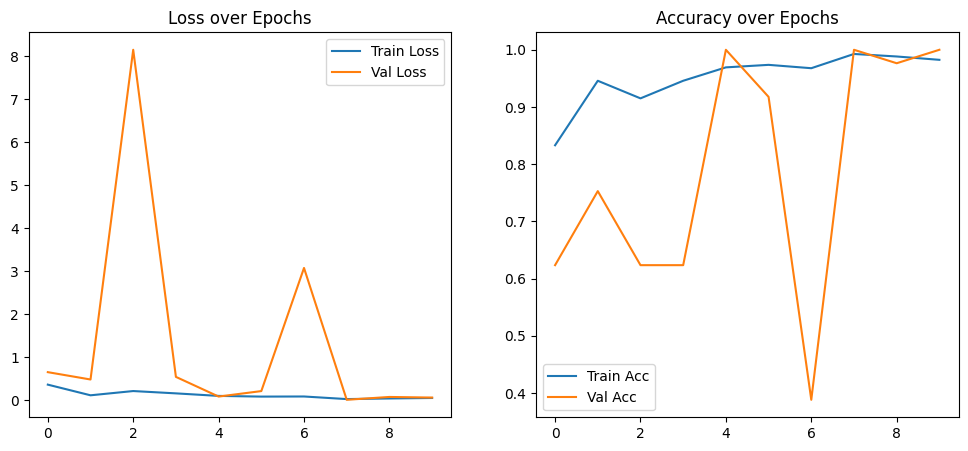

In [13]:
# Accuracy/Loss Plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1,2,2)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Evaluation

### 1. Test Model

In [14]:
model.load_state_dict(torch.load("best_3D_CNN_model.pth"))
test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc*100:.2f}")

Test Accuracy: 100.00


### 2. Confusion Matrix

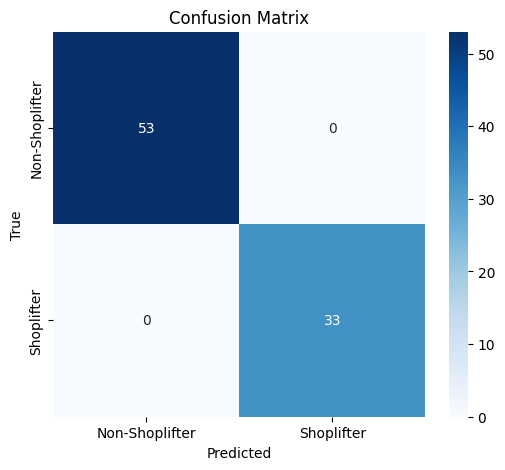

In [15]:
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Shoplifter", "Shoplifter"],
            yticklabels=["Non-Shoplifter", "Shoplifter"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 3. Download the Best Model

In [16]:
from IPython.display import FileLink

FileLink('best_3D_CNN_model.pth')

/kaggle/working/best_3D_CNN_model.pth